In [1]:
import os
import tensorflow as tf
from PIL import Image

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Making Dataframe of train and test for data analysis

In [28]:
def train_df(path):
    labels, class_path = zip(*[(label, os.path.join(path, label, image))
                                for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                                for image in os.listdir(os.path.join(path, label))])
    df = pd.DataFrame({'Class Path': class_path, 'Labels': labels})
    return df

In [29]:
def test_df(path):
    labels, class_path = zip(*[(label, os.path.join(path, label, image))
                              for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                              for image in os.listdir(os.path.join(path, label))])
    test_df = pd.DataFrame({'Class Path': class_path, 'Labels': labels})
    return test_df

In [30]:
training_df = train_df('Training/')
training_df

,Class Path,Labels
0,Training/glioma\Tr-glTr_0000.jpg,glioma
1,Training/glioma\Tr-glTr_0001.jpg,glioma
2,Training/glioma\Tr-glTr_0002.jpg,glioma
3,Training/glioma\Tr-glTr_0003.jpg,glioma
4,Training/glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Training/pituitary\Tr-pi_1452.jpg,pituitary
5708,Training/pituitary\Tr-pi_1453.jpg,pituitary
5709,Training/pituitary\Tr-pi_1454.jpg,pituitary
5710,Training/pituitary\Tr-pi_1455.jpg,pituitary


In [31]:
testing_df = train_df('Testing/')
testing_df

,Class Path,Labels
0,Testing/glioma\Te-glTr_0000.jpg,glioma
1,Testing/glioma\Te-glTr_0001.jpg,glioma
2,Testing/glioma\Te-glTr_0002.jpg,glioma
3,Testing/glioma\Te-glTr_0003.jpg,glioma
4,Testing/glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Testing/pituitary\Te-pi_0295.jpg,pituitary
1307,Testing/pituitary\Te-pi_0296.jpg,pituitary
1308,Testing/pituitary\Te-pi_0297.jpg,pituitary
1309,Testing/pituitary\Te-pi_0298.jpg,pituitary


# Training Dataframe

Text(0.5, 1.0, 'Countplot of Images in each Labels')

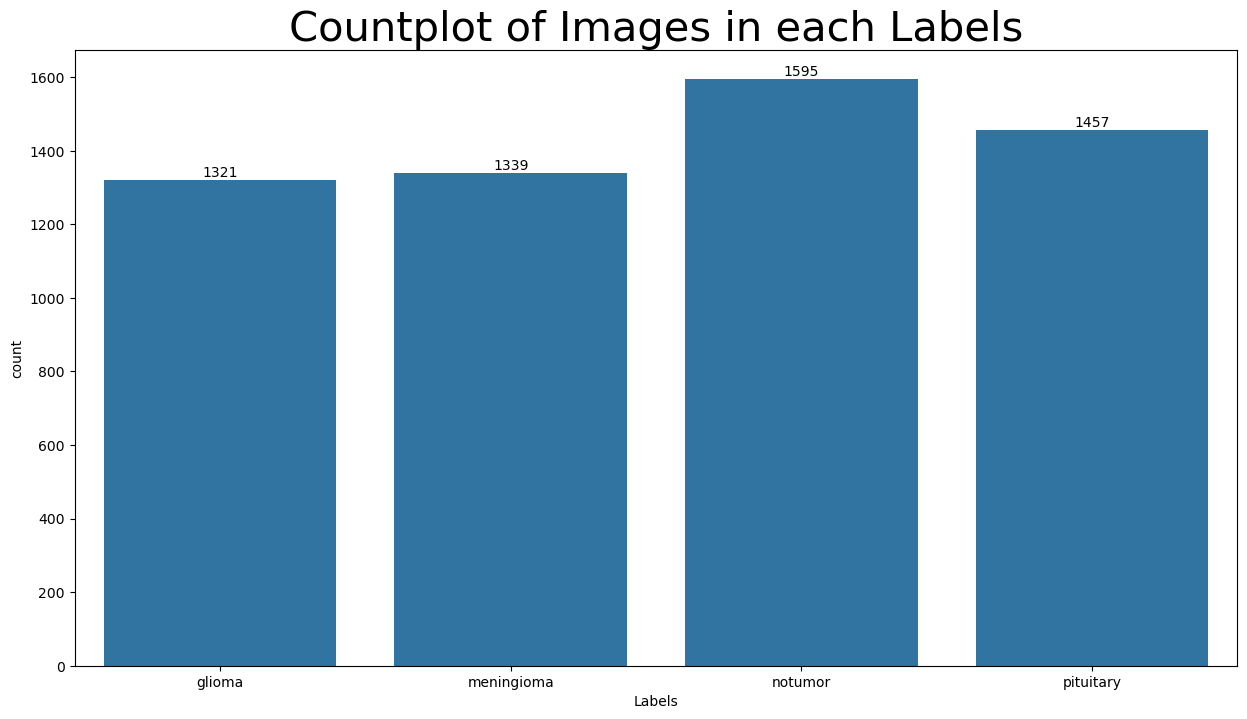

In [36]:
plt.figure(figsize=(15,8))

ax = sns.countplot(x='Labels', data=training_df)
plt.bar_label(ax.containers[0])
plt.title('Countplot of Images in each Labels', fontsize=30)

# Testing Dataframe

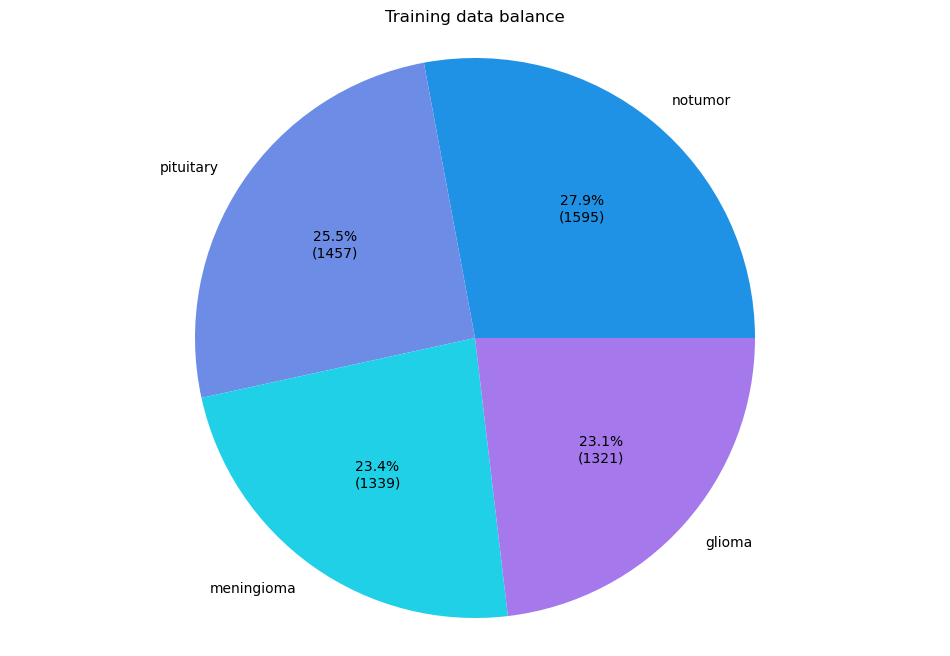

In [37]:
data_balance = training_df.Labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.figure(figsize=(12,8))
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "Training",
            shuffle = True,
            image_size = (255, 255),
            batch_size = 64
        )

Found 5712 files belonging to 4 classes.


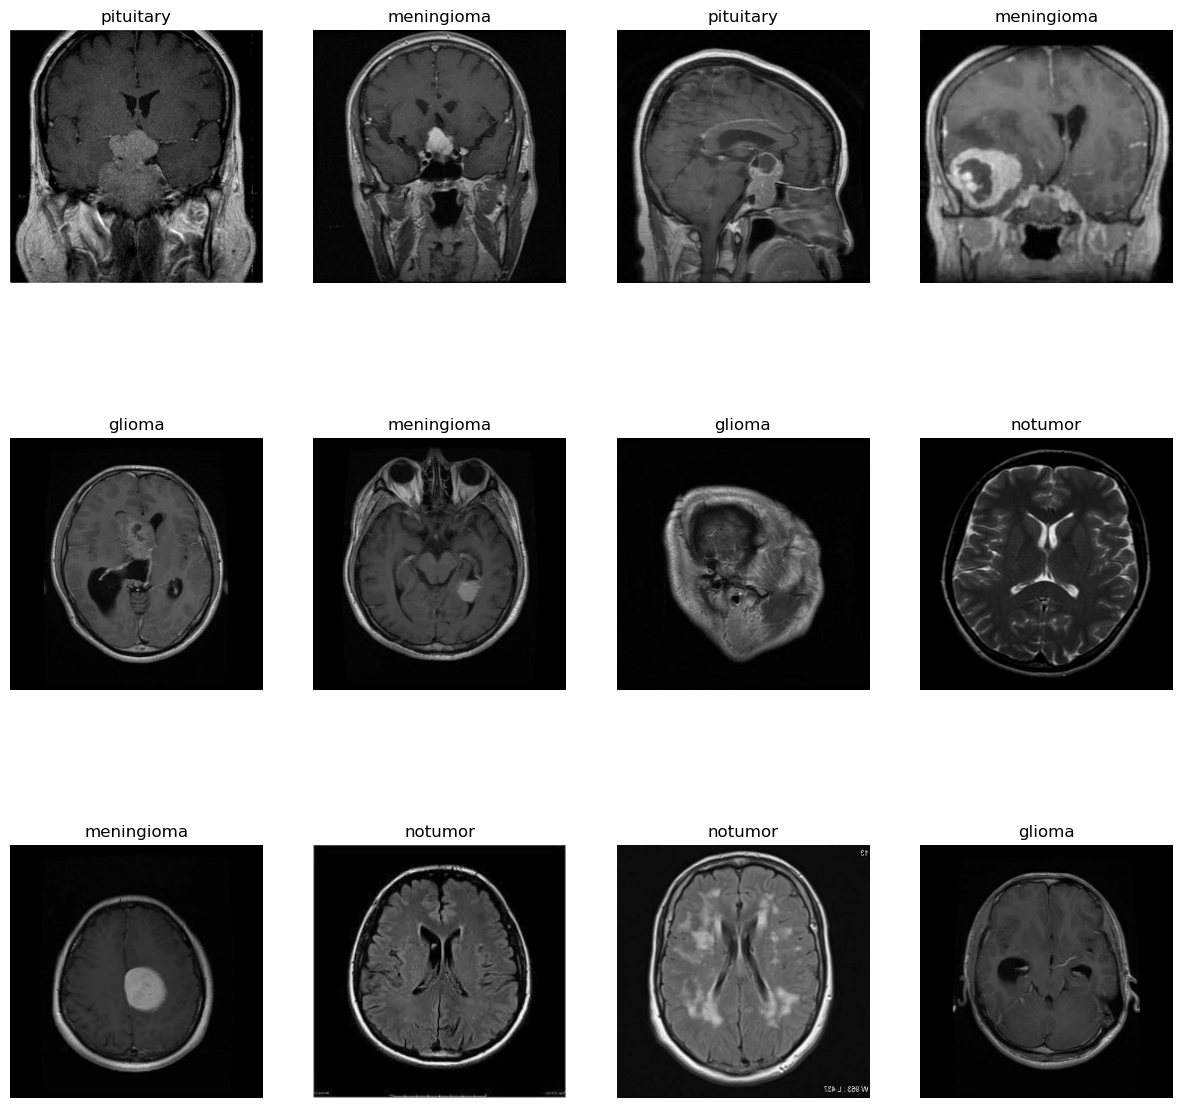

In [39]:
plt.figure(figsize=(15,15))

labels = dataset.class_names

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(labels[label_batch[i]])

# Data Splitting and Preprocessing

In [40]:
# valid and test dataframe
valid_df, test_df = train_test_split(testing_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [41]:
BATCH_SIZE = 16
IMAGE_SIZE = 224

train_gen = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2),
    validation_split=0.2,
)

train_generator = train_gen.flow_from_dataframe(
    training_df,
    x_col='Class Path',
    y_col='Labels',
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)


Found 5712 validated image filenames belonging to 4 classes.


In [42]:
test_gen = ImageDataGenerator(rescale=1/255)


val_generator = test_gen.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Labels',
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Labels',
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=False
)

Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Model Building

In [43]:
input_shape = (224, 224, 3)
n_classes = 4

model = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [44]:
model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision() ,Recall()]
)

In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │      12,845,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [47]:
EPOCHS=10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1,
    shuffle=False
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 162s 444ms/step - accuracy: 0.5969 - loss: 0.9740 - precision_1: 0.7487 - recall_1: 0.4172 - val_accuracy: 0.7969 - val_loss: 0.5199 - val_precision_1: 0.8154 - val_recall_1: 0.7618
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 91s 254ms/step - accuracy: 0.8822 - loss: 0.3189 - precision_1: 0.8944 - recall_1: 0.8607 - val_accuracy: 0.8992 - val_loss: 0.3105 - val_precision_1: 0.9146 - val_recall_1: 0.8824
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 267ms/step - accuracy: 0.9465 - loss: 0.1681 - precision_1: 0.9501 - recall_1: 0.9405 - val_accuracy: 0.9374 - val_loss: 0.1875 - val_precision_1: 0.9415 - val_recall_1: 0.9344
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 98s 276ms/step - accuracy: 0.9731 - loss: 0.0942 - precision_1: 0.9751 - recall_1: 0.9710 - val_accuracy: 0.9466 - val_loss: 0.1578 - val_precision_1: 0.9464 - val_recall_1: 0.9435
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 96s 269ms/step - accuracy: 0.9824 - loss: 0.0500 - precision_1: 0.9838 - re

In [54]:
scores = model.evaluate(test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9498 - loss: 0.2435 - precision_1: 0.9498 - recall_1: 0.9498


In [55]:
history.history['accuracy']

[0.7422969341278076,
 0.8891806602478027,
 0.9408263564109802,
 0.9723389148712158,
 0.9851190447807312,
 0.9942227005958557,
 0.9975489974021912,
 0.9970238208770752,
 0.9989495873451233,
 0.9991246461868286]

In [56]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

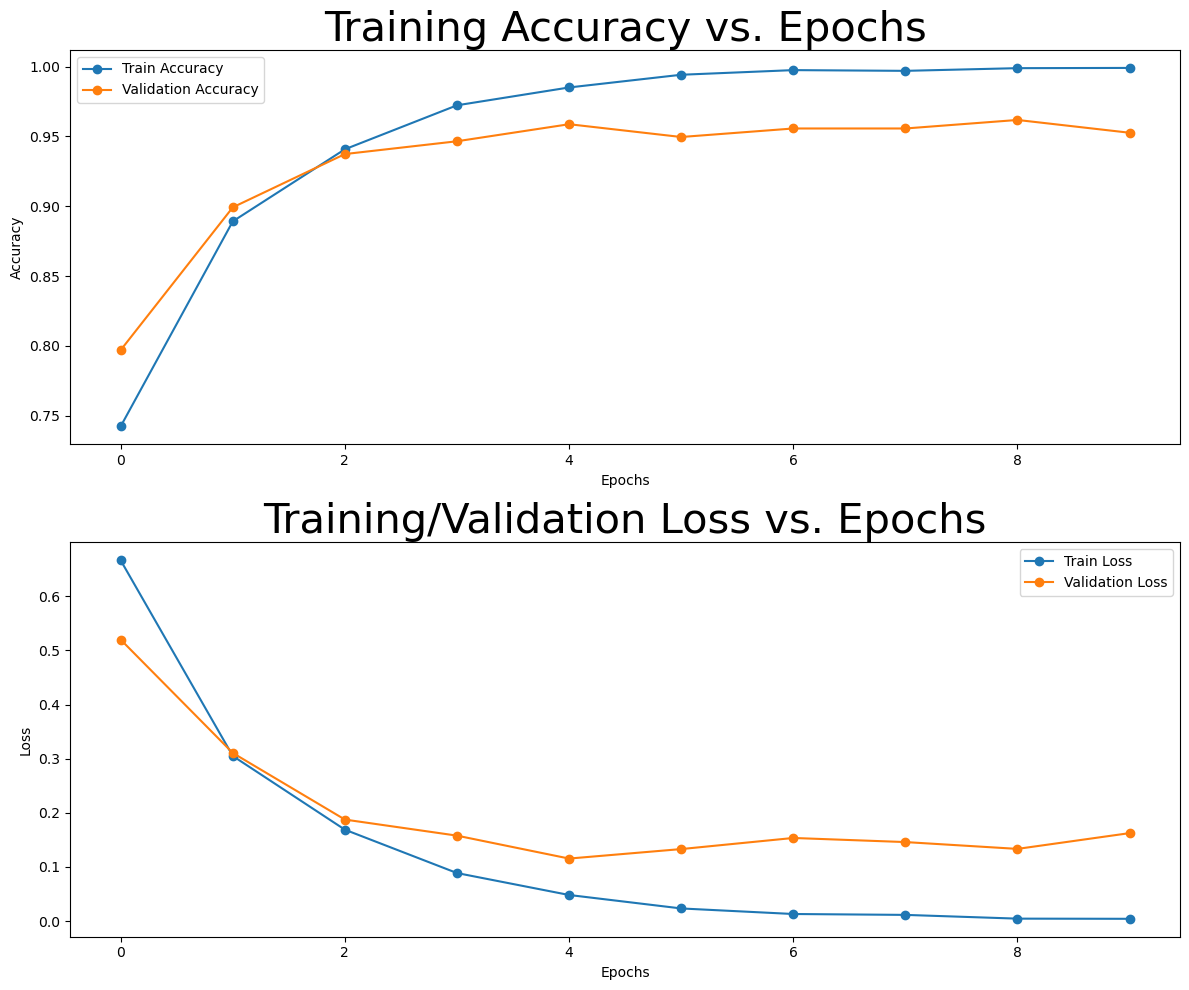

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs', fontsize=30)
ax[0].plot(accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs', fontsize=30)
ax[1].plot(loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       151
           1       0.86      0.93      0.89       164
           2       0.97      1.00      0.98       192
           3       1.00      0.99      1.00       149

    accuracy                           0.95       656
   macro avg       0.95      0.94      0.94       656
weighted avg       0.95      0.95      0.94       656



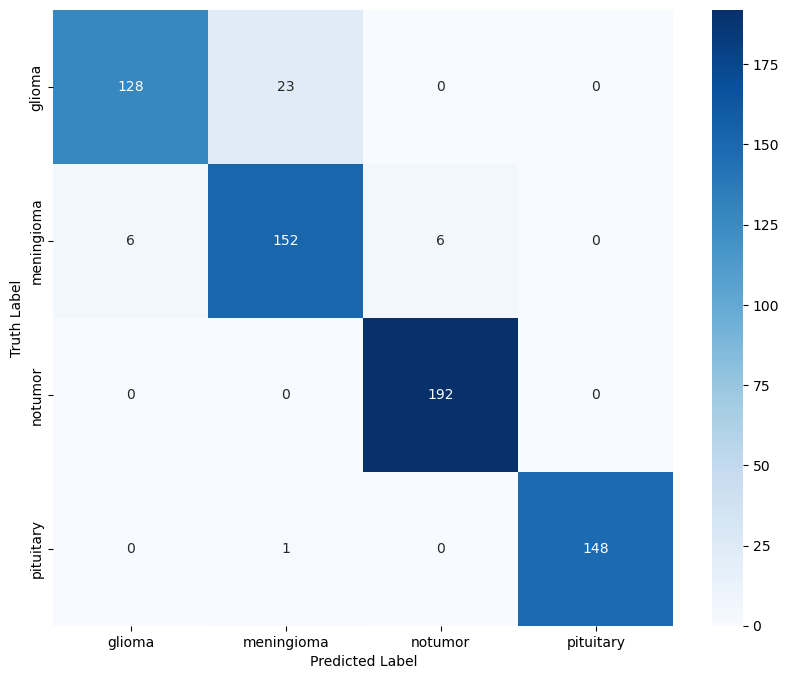

In [60]:
class_labels = test_generator.class_indices
labels = list(class_labels.keys())

con_matrix = confusion_matrix(test_generator.classes, np.argmax(model.predict(test_generator), axis=1))
con_matrix

plt.figure(figsize=(10,8))

print(classification_report(test_generator.classes, np.argmax(model.predict(test_generator), axis=1)))
sns.heatmap(con_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [63]:
model.save('BrainTumorModel.keras')
